# K-nn

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import PCA


In [2]:
# Chargement du script d'importation et formattage des images

%run ./data-importation-and-formatting.py

In [3]:
data_folder = "../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"

lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Bacterial Pneumonia", "Covid", "Normal"],
                                 "img_dir" : lst_dirs_condition})


## K-nn sur les distributions de niveaux de gris

In [4]:
# Calcul de la distribution des niveaux de gris
color_distrib_df = compute_color_distribution_from_dir_imgs(conditions[0])
color_distrib_df['label'] = conditions[0]

for c in range(2,len(conditions)):
    distrib_c = compute_color_distribution_from_dir_imgs(conditions[c])
    distrib_c['label'] = conditions[c]
    color_distrib_df = pd.concat([color_distrib_df,distrib_c])
color_distrib_df = color_distrib_df.reset_index().drop(columns='index')


In [5]:
# Définition de la variable cible et des features
X = color_distrib_df.drop(columns='label')
y = 0 + 1*(color_distrib_df.label=="COVID")
y2 = color_distrib_df.label

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

knn = neighbors.KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [59]:
y_pred = knn.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred))

pd.crosstab(y_pred, y_test, rownames=['pred'], colnames=['true'])


              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3494
           1       0.53      0.40      0.45       739

    accuracy                           0.83      4233
   macro avg       0.71      0.66      0.68      4233
weighted avg       0.82      0.83      0.82      4233



true,0,1
pred,,
0,3237,447
1,257,292


In [74]:
# Avec la métrique KL : TODO
def KL_div(x,y):
    return np.sum(x*np.log(x/y))
def KL_dist(x,y):
    return KL_div(x,y) + KL_div(y,x)
knn_kl = neighbors.KNeighborsClassifier(n_neighbors=10, metric=KL_dist)
knn_kl.fit(X_train, y_train)

KNeighborsClassifier(metric=<function KL_dist at 0x000002C8A1A23CA0>,
                     n_neighbors=10)

In [ ]:
y_pred_kl = knn_kl.predict(X_test)
print(classification_report(y_test, y_pred_kl))

pd.crosstab(y_pred_kl, y_test, rownames=['pred'], colnames=['true'])

In [ ]:
# Optimisation des paramètres 
skf = StratifiedKFold(n_splits=10, shuffle = True)
folds = list(skf.split(X_train, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

grid_param = {
    'n_neighbors' : [5,10,50,100,150],
    'metric' : ['euclidean', 'ChebyshevDistance', 'mahalanobis', 'minkowski'],
    'p' : [0,2,5]
}
grid_knn = GridSearchCV(knn, param_grid = grid_param, cv=folds)
grid_knn.fit(X_train, y_train)

In [69]:
print(grid_knn.score(X_test, y_test))

y_pred_best = grid_knn.predict(X_test)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])

0.8509331443420742
              precision    recall  f1-score   support

           0       0.87      0.97      0.91      3494
           1       0.66      0.30      0.41       739

    accuracy                           0.85      4233
   macro avg       0.76      0.63      0.66      4233
weighted avg       0.83      0.85      0.83      4233



true,0,1
pred,,
0,3382,519
1,112,220


## K-nn sur les résultats d'une PCA

### Sur les images sans masque

In [59]:
# # Importation des images
# img_df = load_img_multiple_cond_in_df

img_df = load_img_multiple_cond_in_df(['Viral Pneumonia', 'COVID'])


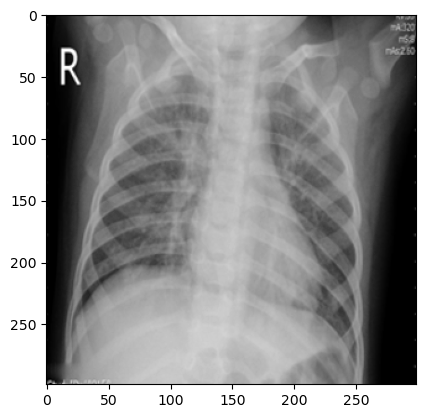

In [5]:
plt.imshow(np.array(img_df.drop(columns='label').iloc[0,:]).reshape(299,299), cmap='gray')

In [6]:
print(img_df.shape)
print(img_df.dtypes.unique())
img_df.head()

(4961, 89402)
[dtype('uint8') dtype('O')]


,0,1,2,3,4,5,6,7,8,9,...,89392,89393,89394,89395,89396,89397,89398,89399,89400,label
0,1,1,2,3,3,3,3,4,11,17,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
1,0,3,9,16,21,24,25,25,25,25,...,36,24,3,4,7,9,10,11,11,Viral Pneumonia
2,0,2,2,5,9,10,29,214,156,49,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
4,138,140,141,143,145,147,148,148,148,149,...,28,28,28,28,28,29,29,29,29,Viral Pneumonia


In [60]:
X = img_df.drop(columns='label')
y = 0 + 1*(img_df.label=="COVID")
# Séparation en échantillons d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
# X_train_pca, X_val_pca, y_train_pca, y_test_pca = train_test_split(X_train, y_train, test_size=0.35, random_state=123)

In [18]:
print(X_train_pca.shape)
y_train_pca.mean()

(2579, 89401)


np.float64(0.7243117487398216)

In [61]:
pca90 = PCA(n_components=0.9, random_state=42)

X_train_pca = pca90.fit_transform(X_train)

print(X_train_pca.shape) 

X_test_pca = pca90.transform(X_test)

print(X_test_pca.shape)

(3968, 50)
(993, 50)


In [62]:
# Instanciation

knn_pca = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

grid_param = {'metric' : ['euclidean', 'chebyshev', 'correlation', 'cosine'],  'n_neighbors' : [2, 3, 5, 10, 50, 100]}

grid_knn = GridSearchCV(knn_pca, param_grid = grid_param, cv=folds)
grid_knn.fit(X_train_pca, y_train)

GridSearchCV(cv=[(array([   1,    2,    4, ..., 3965, 3966, 3967]),
                  array([   0,    3,   21,   22,   26,   27,   28,   42,   44,   53,   57,
         69,   77,   80,   84,   91,   98,  104,  109,  114,  118,  120,
        122,  131,  151,  152,  153,  155,  157,  170,  177,  185,  196,
        198,  203,  207,  219,  222,  226,  229,  230,  232,  237,  239,
        240,  241,  242,  243,  246,  248,  252,  259,  263,  272,  274,
        275,  276,  277,  279,  290,  291,  293,  295,  315,  319,  321,
        326,  327,  330,  333,  336,  341,  342,  346,  349,  362,  363,
        36...
       3765, 3772, 3775, 3777, 3778, 3788, 3795, 3797, 3801, 3802, 3806,
       3810, 3816, 3824, 3825, 3831, 3835, 3840, 3849, 3852, 3855, 3859,
       3860, 3862, 3867, 3870, 3872, 3875, 3876, 3881, 3886, 3892, 3894,
       3899, 3900, 3905, 3908, 3924, 3928, 3930, 3931, 3941, 3944, 3945,
       3948]))],
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'chebyshev', 'correlation',
                                    'cosine'],
                         'n_neighbors': [2, 3, 5, 10, 50, 100]})

In [63]:
print(grid_knn.score(X_test_pca, y_test))

y_pred_best = grid_knn.predict(X_test_pca)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])

0.9818731117824774
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       259
           1       0.99      0.99      0.99       734

    accuracy                           0.98       993
   macro avg       0.97      0.98      0.98       993
weighted avg       0.98      0.98      0.98       993



true,0,1
pred,,
0,252,11
1,7,723


### Sur les images masquées

In [64]:
# # Importation des images
# img_df = load_img_multiple_cond_in_df

img_df = load_masked_img_multiple_cond_in_df(['Viral Pneumonia', 'COVID'])

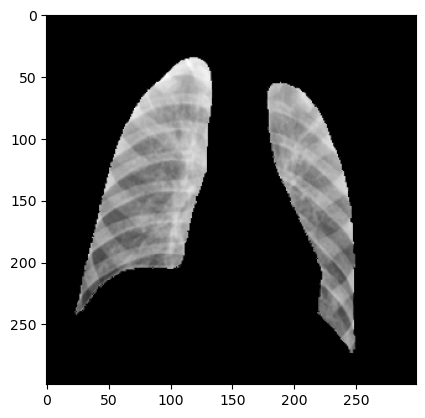

In [11]:
plt.imshow(np.array(img_df.drop(columns='label').iloc[0,:]).reshape(299,299), cmap='gray')

In [69]:
X = img_df.drop(columns='label')
y = 0 + 1*(img_df.label=="COVID")

# Séparation en échantillons d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4961 entries, 0 to 4960
Columns: 89402 entries, 0 to label
dtypes: object(1), uint8(89401)
memory usage: 423.0+ MB


In [70]:
pca90_masks = PCA(n_components=0.9, random_state=42)

X_train_pca = pca90_masks.fit_transform(X_train)

print(X_train_pca.shape) 

X_test_pca = pca90_masks.transform(X_test)

print(X_test_pca.shape)

(3968, 50)
(993, 50)


In [71]:
# Instanciation

knn_pca_masks = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

grid_param = {'metric' : ['euclidean', 'chebyshev', 'correlation', 'cosine'],  'n_neighbors' : [2, 3, 5, 10, 50, 100]}

grid_knn_masks = GridSearchCV(knn_pca_masks, param_grid = grid_param, cv=folds)
grid_knn_masks.fit(X_train_pca, y_train)

print(grid_knn_masks.best_params_)

{'metric': 'cosine', 'n_neighbors': 3}


In [72]:
print(grid_knn_masks.score(X_test_pca, y_test))

y_pred_best = grid_knn_masks.predict(X_test_pca)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])

# Les résultats sont très bons dans l'identification des images COVID (f1-score à 0.99), mais les données dans l'échantillon d'apprentissage sont déséquilibrées (près de 75% de COVID), ce qui
# biaise les résultats.

0.9818731117824774
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       259
           1       0.99      0.99      0.99       734

    accuracy                           0.98       993
   macro avg       0.97      0.98      0.98       993
weighted avg       0.98      0.98      0.98       993



true,0,1
pred,,
0,252,11
1,7,723


### Avec rééquilibrage des classes

In [7]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

ros = RandomOverSampler()
X_ro, y_ro = ros.fit_resample(X_train, y_train)
print('Classes échantillon oversampled',pd.Series(y_ro).value_counts())

Classes échantillon oversampled label
COVID              2882
Viral Pneumonia    2882
Name: count, dtype: int64


In [10]:
print(X_train.shape)
print(X_ro.shape)


(3968, 89401)
(5764, 89401)


In [12]:
pca90_masks_resampled = PCA(n_components=0.9, random_state=42)

X_ro_pca = pca90_masks_resampled.fit_transform(X_ro) 
# 19m42

print(X_ro_pca.shape) 

X_test_pca = pca90_masks_resampled.transform(X_test)

print(X_test_pca.shape)

(5764, 315)
(993, 315)


In [52]:
temp = neighbors.KNeighborsClassifier(metric =  'minkowski', n_neighbors=10, p=1).fit(X_ro_pca, y_ro)
accuracy_score(y_test, temp.predict(X_test_pca))

0.9305135951661632

In [55]:
# Instanciation

knn_pca_masks_resampled = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_ro_pca, y_ro)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

# grid_param = [
#     {'metric' : ['minkowski'],  'n_neighbors' : [2, 3, 5, 10, 50], 'p' : [1,2,5]},
#     {'metric' : ['chebyshev'], 'n_neighbors' : [2, 3, 5, 10, 50]},
#     {'metric' : ['correlation'], 'n_neighbors' : [2, 3, 5, 10, 50]},
#     {'metric' : ['cosine'], 'n_neighbors' : [2, 3, 5, 10, 50]}
# ]
grid_param = {'metric' : ['euclidean', 'chebyshev', 'correlation', 'cosine'],  'n_neighbors' : [2, 3, 5, 10, 50, 100]}

grid_knn_masks_resampled = GridSearchCV(knn_pca_masks_resampled, param_grid = grid_param, cv=folds)
grid_knn_masks_resampled.fit(X_ro_pca, y_ro)


GridSearchCV(cv=[(array([   1,    2,    3, ..., 5760, 5762, 5763]),
                  array([   0,   12,   15, ..., 5756, 5759, 5761])),
                 (array([   0,    1,    2, ..., 5761, 5762, 5763]),
                  array([   6,    7,    9, ..., 5744, 5750, 5754])),
                 (array([   0,    2,    3, ..., 5761, 5762, 5763]),
                  array([   1,    4,    8, ..., 5740, 5749, 5758])),
                 (array([   0,    1,    2, ..., 5761, 5762, 5763]),
                  array([   3,    5,   10, ..., 5751, 5752, 5757])),
                 (array([   0,    1,    3, ..., 5758, 5759, 5761]),
                  array([   2,   19,   20, ..., 5760, 5762, 5763]))],
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['correlation'], 'n_neighbors': [2, 3, 4]})

In [56]:
print(grid_knn_masks_resampled.best_params_)

{'metric': 'correlation', 'n_neighbors': 2}


In [58]:
print("Base d'entraînement :", grid_knn_masks_resampled.score(X_ro_pca, y_ro))

print("Base de test :",grid_knn_masks_resampled.score(X_test_pca, y_test))

y_pred_best = grid_knn_masks_resampled.predict(X_test_pca)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])

Base d'entraînement : 0.9899375433726578
Base de test : 0.94662638469285
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       259
           1       0.98      0.94      0.96       734

    accuracy                           0.95       993
   macro avg       0.92      0.95      0.93       993
weighted avg       0.95      0.95      0.95       993



true,0,1
pred,,
0,248,42
1,11,692
